Домашнее задание к лекции 4.3 «Работа с данными»

Решение выполнения задач необходимо предоставить в виде ссылки на файл формата Jupyter (ipynb) в GitHub.
В файле должны быть сохранены результаты запуска на тестовых данных.
Дано: API для данных о футбольных матчах и командах.
http://api.football-data.org/docs/v1/index.html

Используя kmeans сделать кластеризацию футбольных команд по стоимости и количеству проигрышей, результат отобразить в виде точечного графика для случая из 3 и из 5 кластеров.

Так как данных о стоимости команд нет, попробуем поискать другой интересный показатель

In [1]:
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Scipy
Импортируем функции из библиотеки для кластеризации и векторного квантования.
https://docs.scipy.org/doc/scipy-0.18.1/reference/cluster.vq.html

In [2]:
from scipy.cluster.vq import whiten, kmeans2

In [3]:
def call_api(uri, result_key):
    json = {}
    try:
        json = requests.get(uri, headers = { 'X-Auth-Token': 'c52b7825851b4357af3e06c1888152f0' }).json()
        return json[result_key]
    except:
        print(json)
        return None

Для португальской лиге считать неинтересно, посмотрим, какие лиги еще бывают

In [4]:
leagues = requests.get('http://api.football-data.org/v1/soccerseasons', headers = { 'X-Auth-Token': 'c52b7825851b4357af3e06c1888152f0' }).json()

Есть английская премьер-лига - id 455

In [5]:
leagues[1]

{'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/soccerseasons/445/fixtures'},
  'leagueTable': {'href': 'http://api.football-data.org/v1/soccerseasons/445/leagueTable'},
  'self': {'href': 'http://api.football-data.org/v1/soccerseasons/445'},
  'teams': {'href': 'http://api.football-data.org/v1/soccerseasons/445/teams'}},
 'caption': 'Premier League 2017/18',
 'currentMatchday': 12,
 'id': 445,
 'lastUpdated': '2017-11-19T18:10:06Z',
 'league': 'PL',
 'numberOfGames': 380,
 'numberOfMatchdays': 38,
 'numberOfTeams': 20,
 'year': '2017'}

выкачиваем данные по командам английской премьер-лиге

In [6]:
teams = call_api('http://api.football-data.org/v1/soccerseasons/445/teams', 'teams')
teams

[{'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/57/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/57/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/57'}},
  'code': 'AFC',
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/en/5/53/Arsenal_FC.svg',
  'name': 'Arsenal FC',
  'shortName': 'Arsenal',
  'squadMarketValue': None},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/338/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/338/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/338'}},
  'code': 'LCFC',
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/en/6/63/Leicester02.png',
  'name': 'Leicester City FC',
  'shortName': 'Foxes',
  'squadMarketValue': None},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/346/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/346/players'},
   'self': {'hre

готовим данные для dataframe - добавляем:
    - кол-во англичан среди игроков
    - кол-во игр и отдельно побед, проигрышей и ничьих

In [8]:
for team in teams:
    players = call_api(team['_links']['players']['href'], 'players')
    fixtures = call_api(team['_links']['fixtures']['href'], 'fixtures')
    num_english_players = 0
    for player in players:
        num_english_players += 1 if player['nationality'] == 'England' else 0
    goals = 0
    matches = 0
    wins = 0
    losses = 0
    draws = 0
    for f in fixtures:
        if f['status'] == 'FINISHED':
            matches += 1
            if team['name'] == f['homeTeamName']:
                goals += f['result']['goalsHomeTeam'] if f['result']['goalsHomeTeam'] else 0
                wins += 1 if f['result']['goalsHomeTeam'] > f['result']['goalsAwayTeam'] else 0
                losses += 1 if f['result']['goalsHomeTeam'] < f['result']['goalsAwayTeam'] else 0
                draws += 1 if f['result']['goalsHomeTeam'] == f['result']['goalsAwayTeam'] else 0
            elif team['name'] == f['awayTeamName']:
                goals += f['result']['goalsAwayTeam'] if f['result']['goalsAwayTeam'] else 0
                wins += 1 if f['result']['goalsAwayTeam'] > f['result']['goalsHomeTeam'] else 0
                losses += 1 if f['result']['goalsAwayTeam'] < f['result']['goalsHomeTeam'] else 0
                draws += 1 if f['result']['goalsAwayTeam'] == f['result']['goalsHomeTeam'] else 0
    print('Team "{}", {} players, {} native english players, {} goals, {} matches, {} wins, {} losses, {} draws'.
          format(team['name'], len(players), num_english_players, goals, matches, wins, losses, draws))
    team['players'] = players
    team['english_players'] = num_english_players
    team['goals'] = goals
    team['matches'] = matches
    team['wins'] = wins
    team['losses'] = losses
    team['draws'] = draws

Team "Arsenal FC", 26 players, 7 native english players, 22 goals, 12 matches, 7 wins, 4 losses, 1 draws
Team "Leicester City FC", 26 players, 8 native english players, 16 goals, 12 matches, 3 wins, 5 losses, 4 draws
Team "Watford FC", 31 players, 7 native english players, 19 goals, 12 matches, 5 wins, 4 losses, 3 draws
Team "Liverpool FC", 29 players, 11 native english players, 43 goals, 18 matches, 10 wins, 2 losses, 6 draws
Team "Southampton FC", 27 players, 12 native english players, 9 goals, 12 matches, 3 wins, 5 losses, 4 draws
Team "Swansea City FC", 26 players, 9 native english players, 7 goals, 12 matches, 2 wins, 8 losses, 2 draws
Team "West Bromwich Albion FC", 22 players, 7 native english players, 9 goals, 12 matches, 2 wins, 6 losses, 4 draws
Team "AFC Bournemouth", 27 players, 15 native english players, 11 goals, 12 matches, 4 wins, 7 losses, 1 draws
Team "Everton FC", 30 players, 12 native english players, 12 goals, 12 matches, 3 wins, 6 losses, 3 draws
Team "Stoke City 

загружаем данные в dataframe Pandas

In [9]:
team_for_pd = []
for team in teams:
    if team['players']:
        team_for_pd.append({'name': team['name'],
                            'players': len(team['players']), 'english_players': team['english_players'],
                            'goals': team['goals'],
                            'matches': team['matches'], 
                            'wins': team['wins'], 'losses': team['losses'], 'draws': team['draws']})
team_for_pd

[{'draws': 1,
  'english_players': 7,
  'goals': 22,
  'losses': 4,
  'matches': 12,
  'name': 'Arsenal FC',
  'players': 26,
  'wins': 7},
 {'draws': 4,
  'english_players': 8,
  'goals': 16,
  'losses': 5,
  'matches': 12,
  'name': 'Leicester City FC',
  'players': 26,
  'wins': 3},
 {'draws': 3,
  'english_players': 7,
  'goals': 19,
  'losses': 4,
  'matches': 12,
  'name': 'Watford FC',
  'players': 31,
  'wins': 5},
 {'draws': 6,
  'english_players': 11,
  'goals': 43,
  'losses': 2,
  'matches': 18,
  'name': 'Liverpool FC',
  'players': 29,
  'wins': 10},
 {'draws': 4,
  'english_players': 12,
  'goals': 9,
  'losses': 5,
  'matches': 12,
  'name': 'Southampton FC',
  'players': 27,
  'wins': 3},
 {'draws': 2,
  'english_players': 9,
  'goals': 7,
  'losses': 8,
  'matches': 12,
  'name': 'Swansea City FC',
  'players': 26,
  'wins': 2},
 {'draws': 4,
  'english_players': 7,
  'goals': 9,
  'losses': 6,
  'matches': 12,
  'name': 'West Bromwich Albion FC',
  'players': 22,
  '

In [10]:
teams_pd = pd.DataFrame(team_for_pd)
teams_pd

,draws,english_players,goals,losses,matches,name,players,wins
0,1,7,22,4,12,Arsenal FC,26,7
1,4,8,16,5,12,Leicester City FC,26,3
2,3,7,19,4,12,Watford FC,31,5
3,6,11,43,2,18,Liverpool FC,29,10
4,4,12,9,5,12,Southampton FC,27,3
5,2,9,7,8,12,Swansea City FC,26,2
6,4,7,9,6,12,West Bromwich Albion FC,22,2
7,1,15,11,7,12,AFC Bournemouth,27,4
8,3,12,12,6,12,Everton FC,30,3
9,3,7,13,5,11,Stoke City FC,24,3


завимость голов от кол-ва игроков в команде

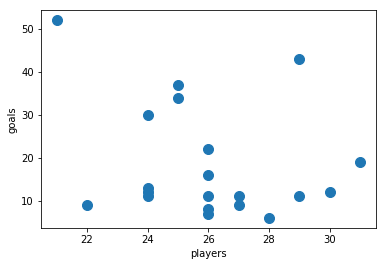

In [11]:
teams_pd.plot.scatter(x='players', y='goals', s=100)

начинаем подбираться к решению - смотрим на зависимость кол-ва проигрышей от кол-ва англичан в команде
есть гипотеза, что команды, где англичан больше играют хуже

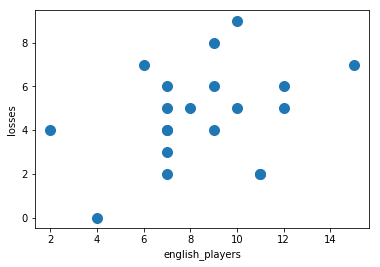

In [12]:
teams_pd.plot.scatter(x='english_players', y='losses', s=100)

неплохо от абослютных показателей перейти к относительным
разные команды сыграли разное кол-во игр, как и общее число игроков отличается между командами

In [13]:
teams_pd['english_players_share'] = round(teams_pd['english_players'] / teams_pd['players'], 2)
teams_pd['losses_share'] = round(teams_pd['losses'] / teams_pd['matches'], 2)

In [14]:
teams_pd

,draws,english_players,goals,losses,matches,name,players,wins,english_players_share,losses_share
0,1,7,22,4,12,Arsenal FC,26,7,0.27,0.33
1,4,8,16,5,12,Leicester City FC,26,3,0.31,0.42
2,3,7,19,4,12,Watford FC,31,5,0.23,0.33
3,6,11,43,2,18,Liverpool FC,29,10,0.38,0.11
4,4,12,9,5,12,Southampton FC,27,3,0.44,0.42
5,2,9,7,8,12,Swansea City FC,26,2,0.35,0.67
6,4,7,9,6,12,West Bromwich Albion FC,22,2,0.32,0.50
7,1,15,11,7,12,AFC Bournemouth,27,4,0.56,0.58
8,3,12,12,6,12,Everton FC,30,3,0.40,0.50
9,3,7,13,5,11,Stoke City FC,24,3,0.29,0.45


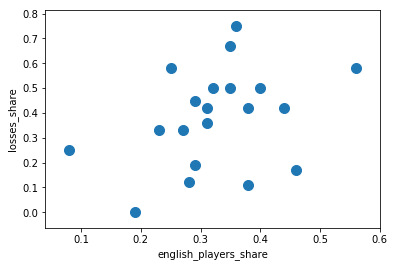

In [15]:
teams_pd.plot.scatter(x='english_players_share', y='losses_share', s=100)

готовим данные для кластеризации k-means

In [39]:
teams_pd[['english_players_share', 'losses_share']]

,english_players_share,losses_share
0,0.27,0.33
1,0.31,0.42
2,0.23,0.33
3,0.38,0.11
4,0.44,0.42
5,0.35,0.67
6,0.32,0.50
7,0.56,0.58
8,0.40,0.50
9,0.29,0.45


In [40]:
whitened = whiten(teams_pd[['english_players_share', 'losses_share']].as_matrix())
whitened

array([[ 2.68859764,  1.71422789],
       [ 3.0869084 ,  2.18174459],
       [ 2.29028688,  1.71422789],
       [ 3.78395223,  0.5714093 ],
       [ 4.38141837,  2.18174459],
       [ 3.48521916,  3.48040208],
       [ 3.18648609,  2.59731498],
       [ 5.57635066,  3.01288538],
       [ 3.98310761,  2.59731498],
       [ 2.88775302,  2.33758349],
       [ 3.58479685,  3.89597248],
       [ 3.78395223,  2.18174459],
       [ 0.79662152,  1.29865749],
       [ 4.58057375,  0.88308709],
       [ 3.0869084 ,  1.87006679],
       [ 1.89197612,  0.        ],
       [ 3.48521916,  2.59731498],
       [ 2.88775302,  0.98697969],
       [ 2.78817533,  0.6233556 ],
       [ 2.48944226,  3.01288538]])

решение для 3 кластеров

In [41]:
centroids, cluster_map = kmeans2(whitened, 3)
centroids, cluster_map

(array([[ 2.34718841,  1.17250219],
        [ 4.18226299,  0.7272482 ],
        [ 3.63005944,  2.73426432]]),
 array([0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 2, 0, 0, 2]))

In [42]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]
colors

['r',
 'b',
 'r',
 'g',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'r',
 'g',
 'r',
 'r',
 'b',
 'r',
 'r',
 'b']

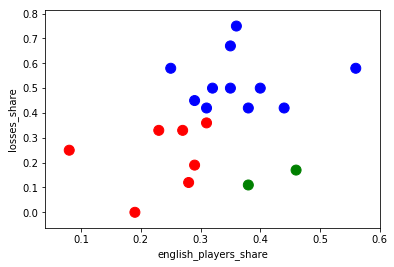

In [43]:
teams_pd.plot.scatter(x='english_players_share', y='losses_share', c=colors, s=100)

решение для 5 кластеров

In [47]:
centroids, cluster_map = kmeans2(whitened, 5)
centroids, cluster_map

(array([[ 4.43120722,  2.49342239],
        [ 2.8166261 ,  2.20400729],
        [ 3.51841172,  3.32456318],
        [ 4.18226299,  0.7272482 ],
        [ 2.0911315 ,  0.7272482 ]]),
 array([1, 1, 1, 3, 0, 2, 1, 0, 0, 1, 2, 0, 4, 3, 1, 4, 2, 4, 4, 1]))

In [48]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]
colors

['g',
 'g',
 'g',
 'y',
 'r',
 'b',
 'g',
 'r',
 'r',
 'g',
 'b',
 'r',
 'm',
 'y',
 'g',
 'm',
 'b',
 'm',
 'm',
 'g']

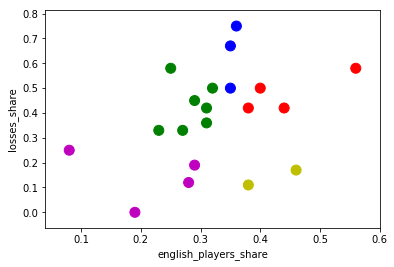

In [49]:
teams_pd.plot.scatter(x='english_players_share', y='losses_share', c=colors, s=100)

Посмотрим на состав "фиолетового" кластера.
В нем оказались как раз команды с низким % прогрышей и соотвественно малой долей англичан.

In [50]:
for i in range(0, 19):
    if colors[i] == 'm':
        print(teams_pd['name'][i])
    i += 1

Chelsea FC
Manchester City FC
Tottenham Hotspur FC
Manchester United FC


"Голубой" кластер, похоже, что состоит из аутсайдеров - менее именитых клубов.

In [51]:
for i in range(0, 19):
    if colors[i] == 'b':
        print(teams_pd['name'][i])
    i += 1

Swansea City FC
Crystal Palace FC
Newcastle United FC
